# This notebook offers some experiments on the paper:


"Globally and Locally Consistent Image Completion", SATOSHI IIZUKA, EDGAR SIMO-SERRA,
HIROSHI ISHIKAWA

The employed code comes from https://github.com/akmtn/pytorch-siggraph2017-inpainting

It requires a PyTorch version below 1.0.

In [1]:
%load_ext autoreload
%autoreload 2

from src.models import _NetCompletion, _NetContext, completionnet_places2
from src.ablation import completionnet_ablation, copy_weights
from src.masking import run_draw
from src.inpaint import inpainting, inpainting2, load_network, random_mask
from src.inpaint import load_mask, load_data, post_processing
from src.train import load_dataset, train_random_mask, train_discriminator, get_networks
import torch
import torchvision.transforms as transforms
from torch.nn.modules.loss import BCELoss, MSELoss
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import cv2
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from moviepy.editor import *
import urllib.request
import numpy as np
import PIL
from PIL import Image, ImageDraw

def numpy2torch(im):
    im = im.transpose((2,0,1))
    return torch.from_numpy(im).float()


filename = "completionnet_places2.t7"
url = "http://hi.cs.waseda.ac.jp/~iizuka/data/completionnet_places2.t7"

if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)
    
model, datamean = load_network()

# Simple tests on an image
Code from https://stackoverflow.com/a/36382158/4986615

Press ESC to quit the windows.

In [ ]:
img = cv2.imread("images/bridge.jpg")
run_draw( img, "mask.png")

In [ ]:
plt.figure()
mask = cv2.imread("mask.png")
plt.imshow(mask)
plt.axis('off')
plt.title("Mask")
plt.show()

In [ ]:
M = load_mask("mask.png", output_shape=(600, 400))
I = load_data("images/flower.jpg", output_shape=(600, 400))
out = inpainting(model, datamean, I, M, postproc=False, skip=False)
vutils.save_image(out, 'out.png', normalize=True)

In [ ]:
plt.figure(figsize=(20,10))
out_im = cv2.imread("out.png")[:,:,::-1] 
plt.imshow(out_im)
plt.axis('off')
plt.title("Output")
plt.show()

# Computing on a short video

In [ ]:
# Next lines are for downloading the required video from Youtube
if not os.path.exists("wwf_forest.mp4"):
    os.system("youtube-dl gpzuVt_mkKs -o wwf_forest.mp4")

clip = VideoFileClip("wwf_forest.mp4").subclip((0,30.0),(0,0.0))
w, h = 600, 400
clip = clip.resize( (w, h) )
clip.ipython_display(fps=20, loop=True, autoplay=True)
M = torch.FloatTensor(1, h, w).fill_(0.)
mask_w, mask_h = np.random.randint(60,100, 2)
px = np.random.randint(0, w-mask_w)
py = np.random.randint(0, h-mask_h)
M[:, py:py+mask_h, px:px+mask_w] = 1.


def inpainting_video(clip, model, datamean, M):
    
    def fl(gf,t):
        im = gf(t)
        h,w,d = im.shape
        im = im.transpose((2,0,1)).astype(np.float64)
        I = torch.from_numpy(im/255.).float()
        out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
        out = (out*255.).transpose((1,2,0)).astype(int)
        return out
    
    return clip.fl(fl)

clip_inpainted = clip.fx(inpainting_video, model, datamean, M)
# clip_inpainted.ipython_display(fps=20, loop=True, autoplay=True)
clip_inpainted.write_videofile('inpainted_30s.mp4', bitrate="3000k")

In [ ]:
VideoFileClip("wwf_forest.mp4").save_frame("wood.jpg", t=26.0)

# Computation of the loss function on a set of random masks
Here we want to draw a metric for the quality of the reconstruction.
We use a sum of a weighted MSE and a binary cross entropy as in the reference paper for training the generator.

A metric does not make so much sense for the loss function, because we don't have the reconstruction to be exactly as before but to be consistent.

In [ ]:
wtl2 = 0.5
bce_loss = BCELoss()
mse_loss = MSELoss()
        
M = random_mask(output_shape=(600, 400))
I = load_data("images/bridge.jpg", output_shape=(600, 400))
out = inpainting(model, datamean, I, M, postproc=False)
out2 = out.float()      

error = wtl2*mse_loss(out2, I) + (1 - wtl2)*bce_loss(out2, I)
print("Normal:", error)

out_proc = post_processing(I, M, out)
out_proc2 = out_proc.float()      
error = wtl2*mse_loss(out_proc2, I) + (1 - wtl2)*bce_loss(out_proc2, I)
print("Post-processing:", error)

# Influence of the hole size

In [ ]:
size = [20,30,50,80,130,210]
N = len(size)
w, h = 400, 400
masks = torch.FloatTensor(N, h, w).fill_(0.)
px = np.random.randint(110, 290)
py = np.random.randint(110, 490)
image = "celeb"
I = load_data(f"images/{image}.jpg", output_shape=(w, h))

for i in range(N):
    half = int(size[i]/2)
    res_dir = os.path.join("results", "hole", image)
    os.makedirs(res_dir, exist_ok=True)
    masks[i, py-half:py+half, px-half:px+half] = 1.
    out = inpainting(model, datamean, I, masks[i:i+1], postproc=False)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-{i}.png'), bbox_inches='tight')
    
    out = inpainting(model, datamean, I, masks[i:i+1], postproc=False, skip=True)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-sanity-{i}.png'), bbox_inches='tight')


# Influence of the hole size inside a video

In [ ]:
W, H = 600, 400
image = "forest"
filename = f"images/{image}.jpg"
input = Image.open(filename)
input = input.resize((W, H))
clip = ImageClip(np.asarray(input)).subclip(0,5)
px = int(W/2)
py = int(H/2)
M = torch.FloatTensor(1, H, W).fill_(0.)


def inpainting_hole(clip, model, datamean, M):
    
    def fl(gf,t):
        im = gf(t)
        h,w,d = im.shape
        half = int(t*20)
        M[:, py-half:py+half, px-half:px+half] = 1.
        im = im.transpose((2,0,1)).astype(np.float64)
        I = torch.from_numpy(im/255.).float()
        out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
        out = (out*255.).transpose((1,2,0)).astype(int)
        return out
    
    return clip.fl(fl)


clip_inpainted = clip.fx(inpainting_hole, model, datamean, M)
# clip_inpainted.ipython_display(fps=20, loop=True, autoplay=True)
clip_inpainted.write_videofile(f'videos/holen-{image}.mp4', fps=15, codec='mpeg4')

# Influence of global context

In [ ]:
size = [30,50,70,90,110,130]
N = len(size)
w, h = 600, 400
half = 30
image = "flower"
input = Image.open(f"images/{image}.jpg")
input.load()
W, H = input.size
px = int(W/2)
py = int(H/2)

for i in range(N):
    res_dir = os.path.join("results", "global_context", image)
    os.makedirs(res_dir, exist_ok=True)
    
    left = max(0, px-half-size[i])
    right = min(px + half + size[i], W)
    top = max(0, py - half - size[i])
    bottom = min(W, py + half + size[i])
    I = input.crop((left, top, right, bottom))
    M = input.copy()
    M.paste((0,0,0), [0,0, *input.size])
    M.paste((255,255,255), [px-half, py-half, px+half, py+half])
    M = M.crop((left, top, right, bottom))
    I = I.resize((w, h))
    I = np.asarray(I).astype(float)/255.0
    I = I.transpose((2,0,1))
    I = torch.from_numpy(I).float()
    M = M.resize((w, h))
    M = np.asarray(M).astype(float)/255.0
    M[M<0.1] = 0.
    M = M.transpose((2,0,1))[:1,:,:]
    M = torch.from_numpy(M).float()
    
    out = inpainting(model, datamean, I, M, postproc=False, skip=False)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-{i}.png'), bbox_inches='tight')
    
    out = inpainting(model, datamean, I, M, postproc=False, skip=True)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-sanity-{i}.png'), bbox_inches='tight')

# Influence of local context
We modify the local context on a side, two sides, ..., all sides of the mask

In [ ]:
width = 3
N = 5
w, h = 600, 400
half = 60
image = "forest"
input = Image.open(f"images/{image}.jpg")
input.load()
W, H = input.size
px = int(W/2)
py = int(H/2)
x1, y1, x2, y2 = px-half-width, py-half-width, px+half+width, py+half+width
points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    
for i in range(N):
    res_dir = os.path.join("results", "local_context", image)
    os.makedirs(res_dir, exist_ok=True)
    
    I = input.copy()
    
    drawing = ImageDraw.Draw(I)
    drawing.line(points[:i+1], fill=(255,0,0), width=width)
    M = input.copy()
    M.paste((0,0,0), [0,0, *input.size])
    M.paste((255,255,255), [px-half, py-half, px+half, py+half])
    I = I.resize((w, h))
    I = np.asarray(I).astype(float)/255.0
    I = I.transpose((2,0,1))
    I = torch.from_numpy(I).float()
    M = M.resize((w, h))
    M = np.asarray(M).astype(float)/255.0
    M[M<0.1] = 0.
    M[M>0.9] = 1.
    M = M.transpose((2,0,1))[:1,:,:]
    M = torch.from_numpy(M).float()
    
    out = inpainting(model, datamean, I, M, postproc=False, skip=False)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-{i}.png'), bbox_inches='tight')
    
    out = inpainting(model, datamean, I, M, postproc=False, skip=True)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'hole-sanity-{i}.png'), bbox_inches='tight')

# Limit of pixels taken into account
Theoretically, the module is not supposed to use pixels outside a region of $307\times307$ pixels. Let's check that!
We need an high resolution image.

In [ ]:
# images = ["flower", "bridge", "celeb", "forest"]
# inputs = [Image.open(f"images/{image}.jpg") for image in images]
images = ["flower", "forest"]
inputs = [Image.open(f"images/{image}.jpg") for image in images]
sizes = [[1200, 600], [1200, 600]]
N = len(sizes)
half = 100
crop = 307
res_dir = os.path.join("results", "limit_context")
os.makedirs(res_dir, exist_ok=True)

def crop_image(input, crop, half, output_shape, is_mask=False):
    W, H = input.size
    px = int(W/2)
    py = int(H/2)
    im = input.copy()
    im.paste((0,0,0), [0,0, *input.size])
    
    if is_mask:
        im.paste((255,255,255), [px-half, py-half, px+half, py+half])
    else:
        points = [px-crop-half, py-half-crop, px+half+crop, py+half+crop]
        cropped = input.crop(points)
        im.paste(cropped, points)
    im = im.resize(output_shape)
    im = np.asarray(im).astype(float)/255.0
    if is_mask:
        im[im<0.1] = 0.
    return im
    

    
for i in range(N):
    w, h = sizes[i]
    input = inputs[i]
    image = images[i]
    
    I = crop_image(input, crop, half, (w, h), is_mask=False)
    I = numpy2torch(I)
    M = crop_image(input, crop, half, (w, h), is_mask=True)
    M = numpy2torch(M[:,:,:1])
    I2 = crop_image(input, 1000, half, (w, h), is_mask=False)
    I2 = numpy2torch(I2)
    M2 = crop_image(input, 1000, half, (w, h), is_mask=True)
    M2 = numpy2torch(M2[:,:,:1])
    
    # cropped inpainting 
    out = inpainting(model, datamean, I, M, postproc=False, skip=False)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'{image}-crop-{i}.png'), bbox_inches='tight')

    # uncropped inpaiting 
    out = inpainting(model, datamean, I2, M2, postproc=False, skip=False)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'{image}-normal-{i}.png'), bbox_inches='tight')

    # sanity check    
    out = inpainting(model, datamean, I, M, postproc=False, skip=True)
    out = out.data.numpy()
    out = out.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, f'{image}-sanity-{i}.png'), bbox_inches='tight')
    
    

# Concatenate similar images

KeyboardInterrupt: 

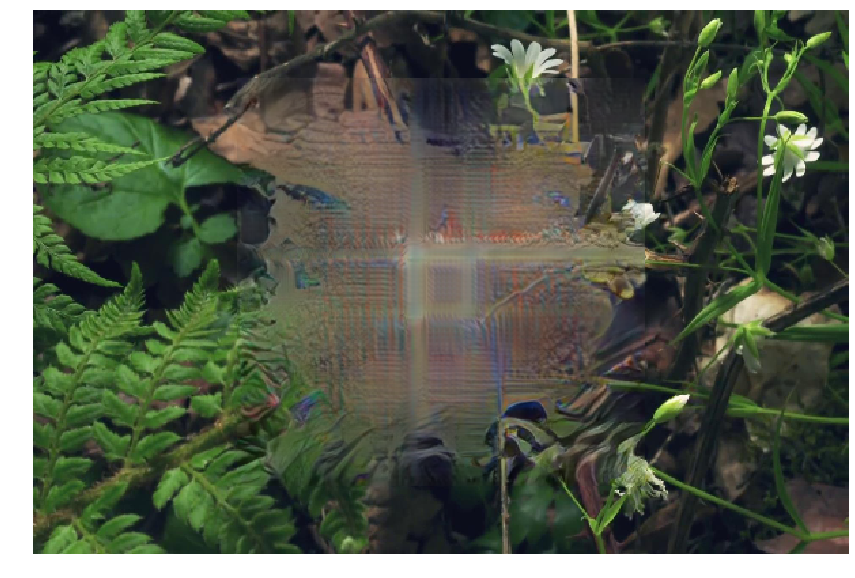

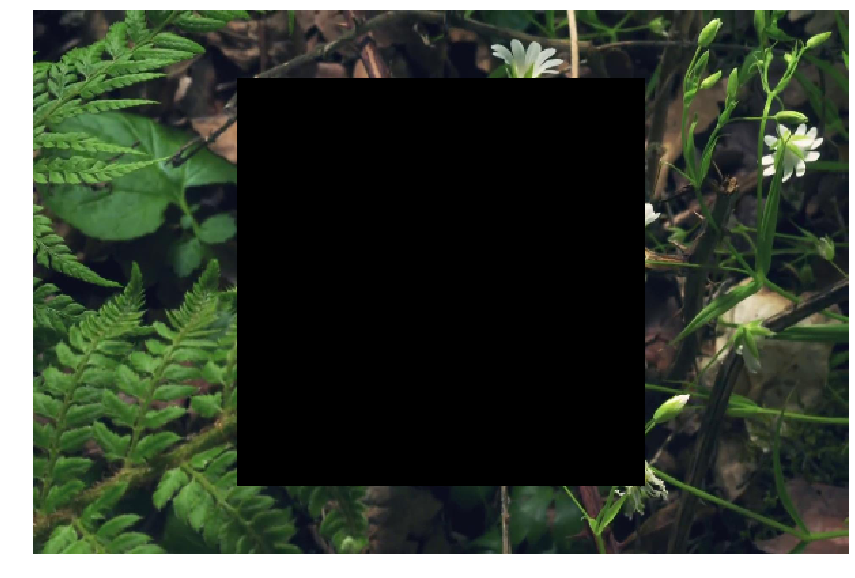

In [2]:
W, H = 600, 400
image = "flower"
filename = f"images/{image}.jpg"
res_dir = os.path.join("results", "concatenate", image)
os.makedirs(res_dir, exist_ok=True)
input = Image.open(filename)
input = input.resize((W, H))
input = np.asarray(input)
I = input.transpose((2,0,1)).astype(float)
I = torch.from_numpy(I/255.).float()
px = int(W/2)
py = int(H/2)
M = torch.FloatTensor(1, H, W).fill_(0.)
half_y = 150
half_w = 150

# failing case: we can see the image is becoming more and more nothing
M[:, py-half_y:py+half_y, px-half_w:px+half_w] = 1.
out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'failing.jpg'), bbox_inches='tight')

# sanity check of the failure case
out = inpainting(model, datamean, I, M, postproc=False, skip=True).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'sanity-check.jpg'), bbox_inches='tight')

# so we concatenate other image around it
images = [Image.open(f"images/{image}{i}.jpg").resize((W, H)) for i in range(1, 10)]
concat = Image.new('RGB', (3*W, 3*H))
limit = 309
for i, im in enumerate(images):
    x_offset = W * (i % 3)
    y_offset = H * (i // 3)
    concat.paste(im, (x_offset, y_offset))
I = np.asarray(concat.resize((W,H))).transpose((2,0,1)).astype(float)/255.
I = torch.from_numpy(I).float()

M = concat.copy()
M.paste((0,0,0), [0,0,3*W,3*H])
py, px = int(3*H/2), int(3*W/2)
M.paste((255,255,255), [px-half_w, py-half_y, px+half_w, py+half_y])
M = np.asarray(M.resize((W,H))).transpose((2,0,1)).astype(float)/255.
M = torch.from_numpy(M[:1,:,:]).float()
out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'concatenate.jpg'), bbox_inches='tight')

# then we deconcatenate:
restored = Image.fromarray(out.astype(np.uint8)).resize((3*W, 3*H)) \
            .crop((W, H, 2*W, 2*H))
plt.figure(figsize=(20,10))
plt.imshow(restored)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'deconcat.jpg'), bbox_inches='tight')


# plt.imshow((I.data.numpy()*255.).transpose((1,2,0)).astype(int))
# plt.show()
# plt.imshow((M.data.numpy()*255.).transpose((1,2,0)).astype(int)[:,:,0])
# plt.show()
# plt.imshow(concat)

# Concatenate images within the same video sequence

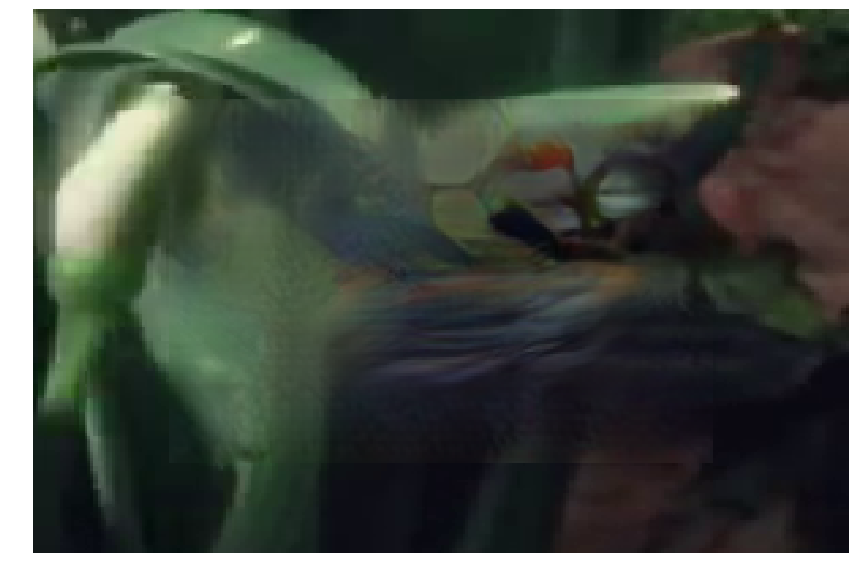

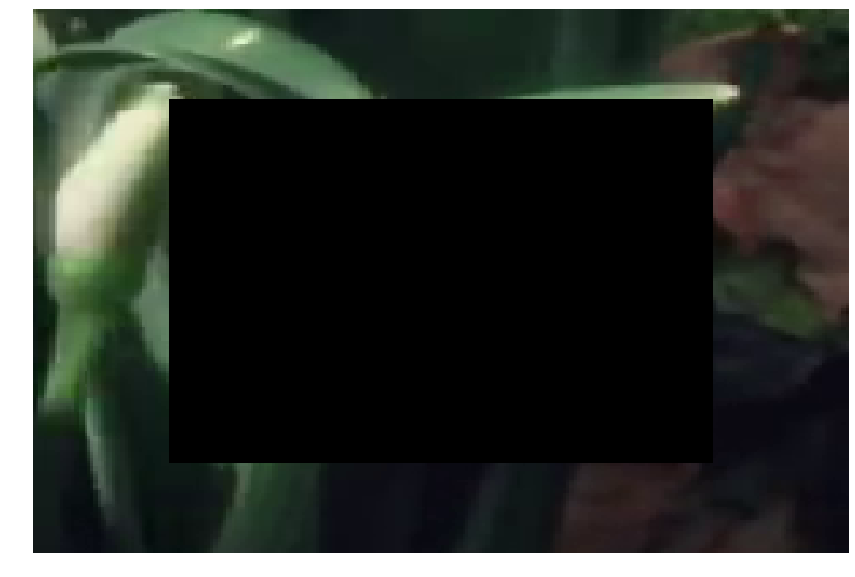

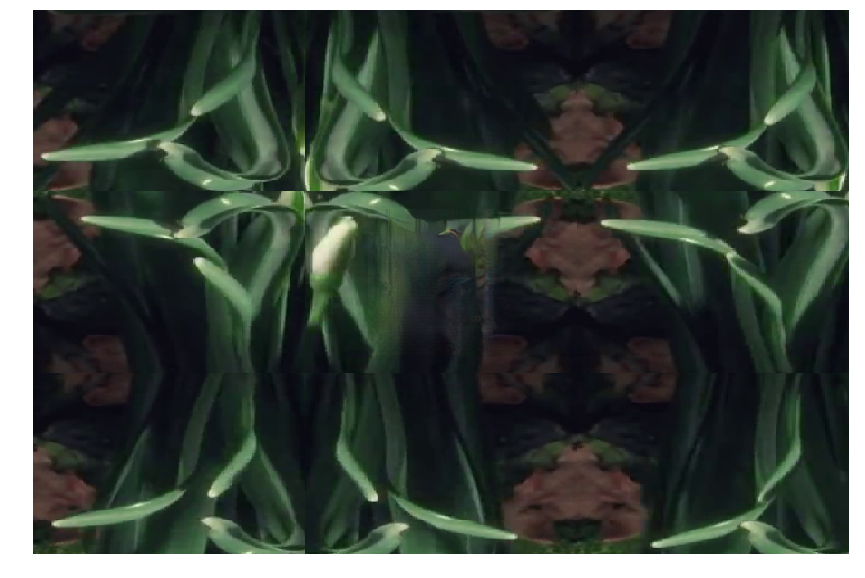

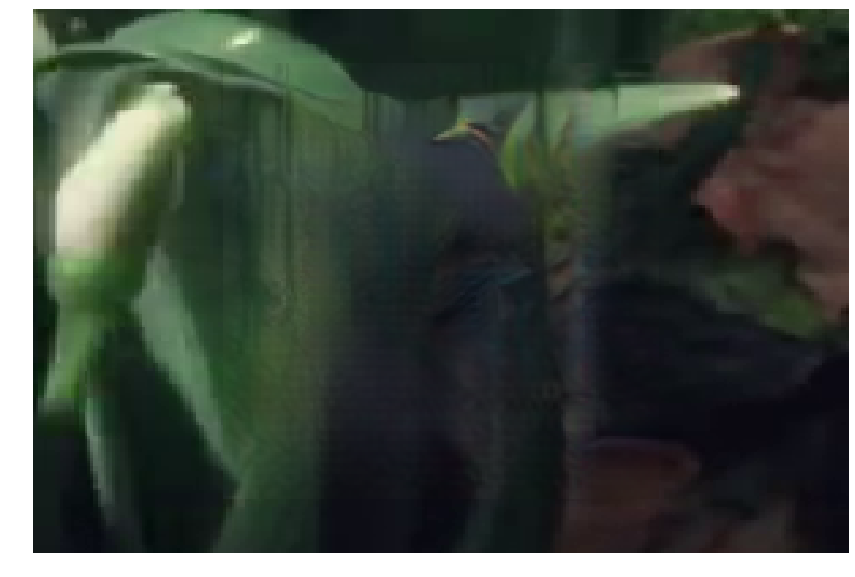

In [3]:
def crop_image2(input, crop, output_shape, masking=0):
    W, H = input.size
    px = int(W/2)
    py = int(H/2)
    im = input.copy()
    if masking > 0:
        im.paste((0,0,0), [0,0, *im.size])
        im.paste((255,255,255), [px-masking, py-masking, px+masking, py+masking])
    im = im.crop([px-crop, py-crop, px+crop, py+crop])
    im = im.resize(output_shape)
    return im

clip = VideoFileClip("wwf_forest.mp4")
W, H = 300, 200
image = "video_extract"
# times = np.arange(23.0,26.7, 0.4)
times = np.arange(55.0,56., 0.1)
orig_images = [Image.fromarray(clip.get_frame(t)) for t in times] 
del clip
crop, size = 120, 80
images = [crop_image2(im, crop, (W, H)) for im in orig_images]
res_dir = os.path.join("results", "concatenate", image)
os.makedirs(res_dir, exist_ok=True)


# failing case: we can see the image is becoming more and more nothing
I = images[4]
I = torch.from_numpy(np.asarray(I).transpose((2,0,1)).astype(float)/255.0).float()
M = crop_image2(orig_images[4], crop, (W, H), size)
M = torch.from_numpy(np.asarray(M).transpose((2,0,1))[:1,:,:].astype(float)/255.0).float()
# M[M<0.1]=0.
out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'failing.jpg'), bbox_inches='tight')

# sanity check of the failure case
out = inpainting(model, datamean, I, M, postproc=False, skip=True).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'sanity-check.jpg'), bbox_inches='tight')

# so we concatenate other image around it
concat = Image.new('RGB', (3*W, 3*H))
ops = [Image.ROTATE_180, Image.FLIP_TOP_BOTTOM, Image.ROTATE_180, \
       Image.FLIP_LEFT_RIGHT, -1, Image.FLIP_LEFT_RIGHT, \
       Image.ROTATE_180, Image.FLIP_TOP_BOTTOM, Image.ROTATE_180]
for i in range(9):
    im = images[i]
    x_offset = W * (i % 3)
    y_offset = H * (i // 3)
    if i != 4:
        im = im.transpose(ops[i])
    concat.paste(im, (x_offset, y_offset))
I = torch.from_numpy(np.asarray(concat).transpose((2,0,1)).astype(float)/255.0).float()
M = concat.copy()
M.paste((0,0,0), [0,0,3*W,3*H])
py, px = int(3*H/2), int(3*W/2)
M.paste((255,255,255), [px-size, py-size, px+size, py+size])
M = torch.from_numpy(np.asarray(M).transpose((2,0,1))[:1,:,:].astype(float)/255.0).float()
out = inpainting(model, datamean, I, M, postproc=False, skip=False).data.numpy()
out = (out*255.).transpose((1,2,0)).astype(int)
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'concatenate.jpg'), bbox_inches='tight')

# then we deconcatenate:
restored = Image.fromarray(out.astype(np.uint8)).resize((3*W, 3*H)) \
            .crop((W, H, 2*W, 2*H))
plt.figure(figsize=(20,10))
plt.imshow(restored)
plt.axis('off')
plt.savefig(os.path.join(res_dir, f'deconcat.jpg'), bbox_inches='tight')

del M, I, concat, out

In [ ]:
%reset

# Iterative procedure to fill a hole

In [ ]:
W, H = 600, 400
n_steps = 5
image = "flower"
filename = f"images/{image}.jpg"
I = Image.open(filename)
I = I.resize((W, H))
I.paste([0,0,0], [])
px = int(W/2)
py = int(H/2)

size = 175

def restore(I, size):
    
    M = torch.FloatTensor(1, H, W).fill_(0.)
    
for i in range(n_steps):
    

# Neural networks

The local and global discriminators were not open-sourced. They are implemented in `models.py`

In [ ]:
completion = _NetCompletion()
summary(completion, input_size=(4, 512, 512))

In [ ]:
from src.models import _NetContext
context = _NetContext()
summary(context, [(3, 128, 128), (3, 256, 256)])

# Training

## Visualize mask and patch
(Violet = global, green = local, yellow = hole)

In [ ]:
from src.train import train_random_mask
mask, patch = train_random_mask(2)
m, p = mask[0,0], patch[0]
m[p[0]:p[2], p[1]:p[3]] += 1
plt.imshow(m.numpy())
plt.axis('off')
plt.show()

## Training the discriminator

In [ ]:
_, context = get_networks(cuda=False)
model, datamean = load_network()
dataloader = load_dataset(dataset="cifar10", dataroot="dataset/cifar10", batch_size=2)
train_discriminator(model, context, dataloader)

# 5. Removing neurons in the pre-trained model
Kind of an ablation study

In [ ]:
dropout = 0.1
A = completionnet_places2
A.load_state_dict(torch.load('completionnet_places2.pth'))
B = completionnet_ablation(dropout)
copy_weights(A, B)

# activate dropout during eval
B.eval()
for m in B.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.train()